Eindopdracht data engineer opleiding Bit-Academy. &copy; Paul Schouten 2022 

# Voorspellen duur energie-neutraal huishouden

Eind 2019 is mijn dak voorzien van zonnepanelen. Deze produceren op een zonnige dag in totaal tussen de 20 en 30kWh. Niet alle energie wordt op dat moment verbruikt door het huis. De overtollige energie stroomt terug het net in. Zonnepanelen zijn erg populair geworden, mede dankzij de subsidie erop. Door de grote hoeveelheid zonnepanelen ontstaat er op momenten een overschot aan energie op het net. Voorheen werd het surplus aan energie weggestreept tegen de hoeveelheid afgenomen energie, de saldeerregeling. 

Echter, de saldeerregeling zal vanaf 2023 langzaam afgebouwd worden. Het is mij overigens nog niet duidelijk over welke periode er beoordeeld gaat worden: Als er op jaarbasis verrekend gaat worden, zal het effect beperkt zijn. Als per dag de hoeveelheid opgewekte en verbruikte energie verrekend gaat worden, dan verandert de situatie. Op een zonnige zomerdag zullen de panelen veel meer energie produceren dan wat er verbruikt kan worden. Op een sombere winterdag zal dit andersom zijn: er zal dan meer energie verbruikt dan wat er opgewekt zal worden. Een oplossing hiervoor zou het opslaan van energie kunnen zijn. Een lange periode aan energie opslaan is geen reële situatie: per jaar wordt ongeveer 3000kWh energie verbruikt. Dan zou er (geschat) 400kWh energie opgeslagen moeten worden om door de drie donkerste maanden te komen. Een optie die wel mogelijk is, is het gebruik van een thuisaccu. De consumentenversies hebben een capaciteit tussen de 4 en 10kWh. 

Aangezien de opbrengst van zonnepanelen afhankelijk is van onder andere het weer, is bij mij de vraag ontstaan: kan op basis van een aantal parameters deze opbrengst voorspeld worden? De uitkomst hiervan bepaalt hoe lang er (met een buffer van 7kWh) energie-neutraal overbrugd kan worden. De aanname hierbij is dat het verbruik van energie gemiddeld wordt per dag en dat een buffer ideaal werkt.

Dit kan opgesplitst worden in de volgende onderdelen:
- Hoeveel energie is geproduceerd in het verleden?
- Wat was het weer in deze periode?
- Kunnen deze gegevens gecombineerd worden tot één dataset?
- Kan met deze dataset voorspeld worden wat de energieopbrengst gaan zijn?
- Hoe lang zal dan een (fictieve) batterij meegaan, is het mogelijk om een langere periode energie-neutraal te overbruggen?

Het opzoeken van de energieproductie is te vinden in `ophalen_solaredge.py`, het opzoeken van het weer in `ophalen_weer.py`. De weersvoorspelling is te vinden in `ophalen_weersvoorspelling.py`. De dataset wordt gecombineerd in `build_dataset.py`. Voor het gemak `import`eert deze file de voorgaande drie files. De verdere analyse staat hierbeneden uitgewerkt.


## Data analyse

Van de verzamelde data wordt eerst onderzocht of er een onderlinge samenhang is. Seaborn heeft hiervoor `pairplot`, of met meer geavanceerde opties `PairGrid`. In deze plot wordt iedere parameter ten opzichte van alle andere parameters geplot. In de onderstaande grafiek is ervoor gekozen om op de diagonaal de verdeling van de parameter zelf te tekenen. Onder de diagonaal staat een _scatterplot_, boven de diagonaal een _kdeplot_. KDE staat in dit geval voor _kernel density estimation_. Deze is het gemakkelijkst te omschrijven als een twee dimensionaal histogram, waar de diepte van de kleur het aantal waarnemingen weergeeft. 

In [1]:
import sqlite3
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

# Database inlezen
conn = sqlite3.connect("database.db")
data = pd.read_sql('SELECT * FROM dataset', conn)
conn.close()

# Voor de zekerheid NaN weglaten (mochten ze er zijn)
data.dropna(axis=0, inplace=True)

# Duur_neerslag uit dataset halen, 
dataset = data.drop(columns=["duur_neerslag"])


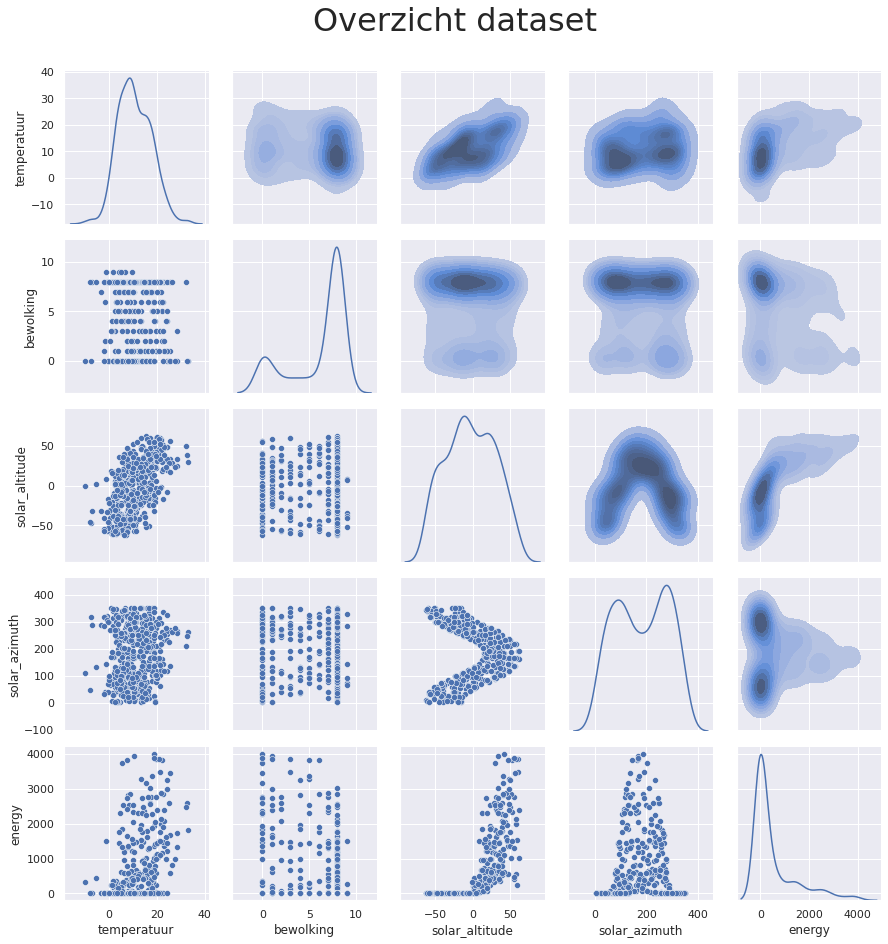

In [2]:
# Pair plot tekenen, in een apart code blok, 
# LET OP: genereren duurt lang --> .sample(n)
sns.set_theme()
g = sns.PairGrid(dataset.sample(500), diag_sharey=False);
g.map_lower(sns.scatterplot)
g.map_upper(sns.kdeplot, fill=True)
g.map_diag(sns.kdeplot)
g.fig.suptitle('Overzicht dataset', y=1.05, fontsize=32);

Een overduidelijk (lineair) verband is niet zichtbaar. De temperatuur ziet er redelijk normaal verdeeld uit. De bewolking laat een bimodale verdeling zien, is er óf geen bewolking óf veel. De stand van de zon geeft een redelijk mooi beeld: hoe hoger de zon staat, hoe meer energie geproduceerd wordt. In de verdraaiing (azimuth) van de zon is te zien dat wanneer de zon in het Zuiden staat de energieproductie het hoogst is. De gegenereerde energie laat een grote piek zien vlak bij de nul. Dit is ook wel te verwachten: er wordt maar op een paar momenten een piekvermogen geleverd. 

Ondanks de grote spreiding op de getallen ziet het er naar uit dat wanneer het warmer is dat er meer energie geproduceerd wordt. Dit is logisch: in de zomer is is het warmer, omdat er meer zon is. Hierdoor wordt er dus ook meer energie geleverd. Een tegenvaller is de bewolking: op het eerste gezicht wordt er maar een beetje minder energie geproduceerd bij hogere bewolkingsgetallen. 

Onderstaand is een 3d grafiek getekend. Op de x- en y-as staat de positie van de zon. De z-as geeft de hoeveelheid geproduceerde energie weer. Met de kleur van de bolletjes wordt de hoeveelheid bewolking aangegeven; een hogere helderheid geeft minder bewolking aan.

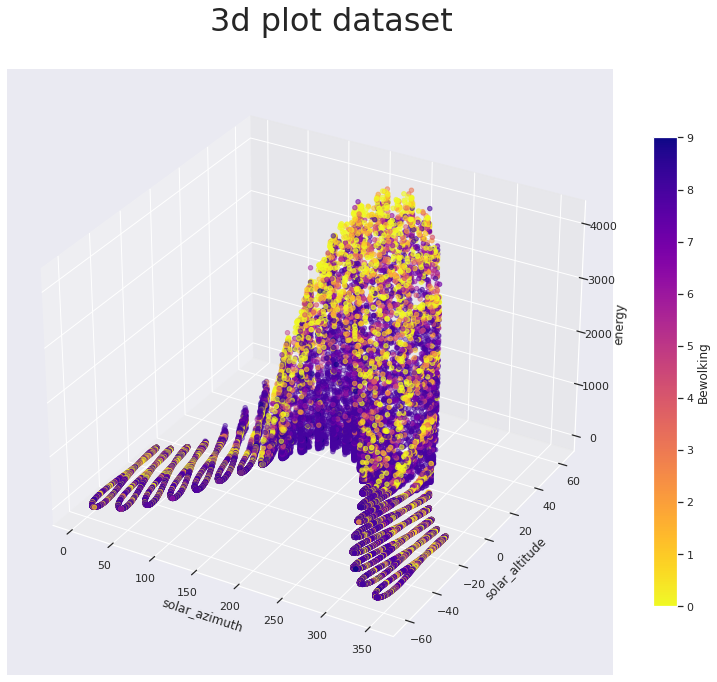

In [3]:
# 3d grafiek tekenen, 
# x en y: stand zon
# z: energie
# c: bewolking
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

x = dataset["solar_azimuth"]
y = dataset["solar_altitude"]
z = dataset["energy"]
c = dataset["bewolking"]

p = ax.scatter(x, y, z, c=c, marker='o', cmap=plt.cm.plasma_r)
ax.set_xlabel('solar_azimuth')
ax.set_ylabel('solar_altitude')
ax.set_zlabel('energy')

plt.rcParams['axes.grid'] = False
cbar = fig.colorbar(p, fraction=0.035, pad=0.06);
cbar.set_label("Bewolking")

fig.suptitle('3d plot dataset', y=0.925, fontsize=32)
plt.show()


Ook in deze plot is te zien dat door de dag heen bij een hogere stand van de zon (solar_altitude) èn minder bewolking (gele bolletjes) er meer energie geproduceerd wordt.

## Modelleren

TODO: tekst typen, uitleg
Om te kijken of we de opbrengst kunnen gaan voorspellen worden er een machine learn model gebruikt

### kNN

Het eerste model wat gebruikt is kNN. Dit staat voor (het aantal _k_) **k N**earest **N**eighbours. Normaal gesproken wordt dit model vooral gebruikt bij het classificeren van items, maar deze is ook te gebruiken voor regressie. Het verschil tussen classificeren en regressie is in deze zin het verschil tussen bijvoorbeeld het voorspellen van "het is half bewolkt" (in een vaste omschrijving) en het bepalen van de geproduceerde hoeveelheid energie (dit is een continue schaal).

In [23]:
# Eerste run met kNN model
# - Data splitsen en inschalen
# - Data fitten, resultaat laten zien
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

# Opsplitsen dataset
X = dataset[["temperatuur", "bewolking", "solar_altitude", "solar_azimuth"]]
y = dataset[["energy"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Omzetten data naar standaardverdeling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# kNN model opstarten, met standaard parameters
knn_model = KNeighborsRegressor()

# Data fitten aan model
knn_model.fit(X_train, y_train)

# Voorspelling berekenen, matchen aan train set
print('Train set:')
score = knn_model.score(X_train, y_train)   # score is r²
print(f'r²: {score:.2f}')

# Afwijking t.o.v. model uitrekenen
predicted_train = knn_model.predict(X_train)
mse = mean_squared_error(y_train, predicted_train)
rmse = sqrt(mse)
print(f'RMSE: {rmse:.0f}')

# Matchen aan test set
print('\nTest set:')
score = knn_model.score(X_test, y_test)
print(f'r²: {score:.2f}')

# Afwijking t.o.v. model uitrekenen
predicted_test = knn_model.predict(X_test)
mse = mean_squared_error(y_test, predicted_test)
rmse = sqrt(mse)
print(f'RMSE: {rmse:.0f}')

Train set:
r²: 0.90
RMSE: 308

Test set:
r²: 0.84
RMSE: 387


Hoe nauwkeurig een model de uitkomst voorspelt is uit te drukken met de [determinatiecoëfficiënt](https://en.wikipedia.org/wiki/Coefficient_of_determination). Dit getal ligt tussen de 0 (totaal geen verband met elkaar) tot 1 (perfect verband). Een r² van 0.90 voor de trainingsset en 0.84 voor de testset is redelijk goed te noemen. Met meer statistiek is een uitspraak met hogere betrouwbaarheid te bepalen, deze wordt hier achterwege gelaten. Wel wordt de [RMSE](https://www.statisticshowto.com/probability-and-statistics/regression-analysis/rmse-root-mean-square-error) uitgerekend, dit is een maat voor hoever de datapunten van de regressielijn af liggen. Met beide parameters kan vergeleken worden of een aanpassing in het model een verbetering of juist een verslechtering oplevert.

#### Optimaliseren van parameters

Met `GridSearchCV` van `sklearn` kan bepaald worden welke parameters optimaal zijn voor het voorspellen van deze dataset. In principe is deze module te vergelijken met een _loop_ waar de gevraagde parameters uitgeprobeerd worden. De beste _fit_ wordt als resultaat teruggeven.

In [5]:
# Bepalen welke parameters beste zijn voor de voorspelling
from sklearn.model_selection import GridSearchCV

# Welke parameters te optimaliseren
parameters = { 
    "n_neighbors": range(1, 50),
    "weights": ["uniform", "distance"],
    "p": [1, 2]
}

# Zoeken naar beste parameters (duurt ff)
# Met n_jobs=-1 worden alle processors (threads) gebruikt,
# TLDR: Laptop doet brrrr
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters, n_jobs=-1)
gridsearch.fit(X_train, y_train)
best_params = gridsearch.best_params_

print(f'Best parameters: {best_params}')

# Herhalen kNN model met optimale instellingen
# kNN model opstarten, met uitkomst gridsearch
knn_model = KNeighborsRegressor(
                n_neighbors=best_params["n_neighbors"],
                weights=best_params["weights"],
                p=best_params["p"])

# Data fitten aan model
knn_model.fit(X_train, y_train)

# Voorspelling berekenen, matchen aan train set
print('\nTrain set:')
score = knn_model.score(X_train, y_train)   # score is r²
print(f'r²: {score:.2f}')

# Afwijking t.o.v. model uitrekenen
predicted_train = knn_model.predict(X_train)
mse = mean_squared_error(y_train, predicted_train)
rmse = sqrt(mse)
print(f'RMSE: {rmse:.0f}')

# Matchen aan test set
print('\nTest set:')
score = knn_model.score(X_test, y_test)
print(f'r²: {score:.2f}')

# Afwijking t.o.v. model uitrekenen
predicted_test = knn_model.predict(X_test)
mse = mean_squared_error(y_test, predicted_test)
rmse = sqrt(mse)
print(f'RMSE: {rmse:.0f}')


Best parameters: {'n_neighbors': 30, 'p': 1, 'weights': 'distance'}

Train set:
r²: 1.00
RMSE: 13

Test set:
r²: 0.86
RMSE: 361


Hierboven is te zien dat GridSearch een uitstekend resultaat oplevert: een r² van 1.00 en de daarbij behorende RMSE van 0. Aan de test set is te zien dat dit erg optimistisch is: hier gaat de r² maar een klein beetje omhoog: van 0.84 naar 0.86. De RMSE daalt ongeveer 5\%.

#### Nauwkeurigheid model

De nauwkeurigheid van de test-set voorspelling is weergegeven in de onderstaande grafiek: er zit nogal wat spreiding op de voorspelling. In het ideale geval zullen alle punten op de diagonaal liggen. Beneden ongeveer 1500 Wh is er een overschatting van de energieproductie, erboven lijkt het een onderschatting. Dit kan aan het gekozen model liggen, maar ook aan de verdeling van de hoeveelheid data. Er is meer data in het lage gebied ten opzichte van de hoeveelheid gegevens in het hoge gebied.

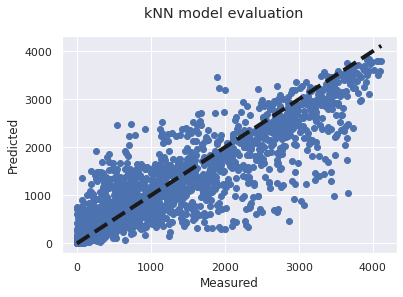

In [6]:
# Grafiek tekenen, evaluatie voorspelling
sns.set_theme()
fig, ax = plt.subplots()
ax.scatter(y_test, predicted_test)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
fig.suptitle("kNN model evaluation")
plt.show()

### XGBoost

TODO: XGBoost uitleggen. E**x**treme **G**radient **B**oost.



In [5]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

# Opsplitsen dataset
X = dataset[["temperatuur", "bewolking", "solar_altitude", "solar_azimuth"]]
y = dataset[["energy"]]

# split into train and test set
# Note: this is on a NON standardized dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Learning API uses a dmatrix
dmatrix = xgb.DMatrix(data=X_train, label=y_train)

# Parameters for training model
params = {'objective':'reg:squarederror'}

# Train model with parameters and
# look at 'rmse' (minimize)
# maximum 250 rounds
# stop when result does not improve in 3 opeenvolgende iteraties
trained_model = xgb.train(params=params,
                          dtrain=dmatrix,
                          evals=[(dmatrix, 'rmse')],
                          verbose_eval=500,
                          num_boost_round=5000,
                          early_stopping_rounds=3)

print(f'Num rounds: {trained_model.num_boosted_rounds()}')

# Check prediction for train set
print('\nTrain set:')
pred_train = trained_model.predict(xgb.DMatrix(data=X_train))

score = r2_score(y_train, pred_train)
print(f'r²: {score:.2f}')
print(f'RMSE train set: {sqrt(mean_squared_error(y_train, pred_train)):.2f}')

# Check prediction for test set
print('\nTest set:')
pred_test = trained_model.predict(xgb.DMatrix(data=X_test))

score = r2_score(y_test, pred_test)
print(f'r²: {score:.2f}')
print(f'RMSE test: {sqrt(mean_squared_error(y_test, pred_test)):.2f}') 


[0]	rmse-rmse:813.38007


/home/paulschouten/Documents/bit-academy/data-engineer-eindopdracht/venv/lib64/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[500]	rmse-rmse:87.78368
[1000]	rmse-rmse:35.83376
[1500]	rmse-rmse:18.11570
[2000]	rmse-rmse:12.08910
[2500]	rmse-rmse:10.39515
[3000]	rmse-rmse:9.94059
[3500]	rmse-rmse:9.79820
[4000]	rmse-rmse:9.75068
[4500]	rmse-rmse:9.73233
[4999]	rmse-rmse:9.72563
Num rounds: 5000

Train set:
r²: 1.00
RMSE train set: 9.73

Test set:


/home/paulschouten/Documents/bit-academy/data-engineer-eindopdracht/venv/lib64/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


r²: 0.82
RMSE test: 411.30


### Optimaliseren XGBoost

Nodig?

Let op: dit duurt een tijdje. Op de dataset worden verschillende modelparameters getest. Deze worden verzameld in een DataFrame. Het verschil tussen de beste en slechtste is gering. Vanwege het lage verschil wordt het model standaard gebruikt


In [6]:
from itertools import product
import time

# Learning API uses a dmatrix
dmatrix = xgb.DMatrix(data=X, label=y) 

# Functie die model met parameters x[...] uitvoert.
# met CrossValidation wordt het model getraind en
# geëvalueerd. Het resultaat wordt weer teruggegeven
def test_parameters(x):
    # Parameters for training model
    params = {'objective':'reg:squarederror',
              'eval_metric':'rmse',
              'eta': x[0],
              'gamma': x[1],
              'max_depth': int(x[2]),
              'tree_method': 'auto'}
    
    print(f'Testing: {params}') 
    
    # Cross validation uitvoeren,
    # Het model splitst de data in _nfold_ delen op
    # en traint en valideert over ieder stuk
    xgb_cv = xgb.cv(dtrain=dmatrix, 
                    params=params, 
                    nfold=5, 
                    metrics = 'rmse',
                    num_boost_round=10000,
                    early_stopping_rounds=3,
                    verbose_eval=100)
    
    # Return de laatste regel
    return xgb_cv[-1:].values[0]

# Maak een search grid, itertools.product van welke waarden voor welke items
# - eta aka learning_rate: kleinere stappen voorkomt overfitting, range: 0-1 (0.3)
# - gamma aks min_split_loss: minimum wat een split aan verbetering moet geven, range: 0--> inf (0)
# - max_depth: maximum diepte van de tree te groot is risico overfitting, range 0--> inf (6)
# Dit zijn de eerste 3 parameters van xgboost:
# https://xgboost.readthedocs.io/en/stable/parameter.html

# 1e run: beste fit met gamma = 0
# grid = pd.DataFrame(product([0.1, 0.3, 0.5], [0, 1, 10], [3, 6, 10]), columns=['eta', 'gamma', 'max_depth'])
# 2e run: gamma=0, meer stapjes in eta
# grid = pd.DataFrame(product([0.05, 0.1, 0.15], [0, 1], [3, 6, 10]), columns=['eta', 'gamma', 'max_depth'])
# 3e run: max_depth = 6, lagere eta
grid = pd.DataFrame(product([0.025, 0.05, 0.725, 0.1, 0.3], [0, 1, 2, 5, 50, 1000], [3, 6, 10]), columns=['eta', 'gamma', 'max_depth'])


# Voor iedere regel in _grid_ (set aan parameters) de _fit_ functie aanroepen
time_start = time.time()
grid[['train-mean','train-std', 'test-mean','test-std']] = grid.apply(test_parameters, axis=1, result_type='expand')
time_done = time.time()

print(f"\nBeste test: \n{grid[grid['test-mean'] == grid['test-mean'].min()]}")
print(f"\nBeste train: \n{grid[grid['train-mean'] == grid['train-mean'].min()]}")

print(f'Tijd nodig: {(time_done - time_start):.1f} sec')
# resultaten laten zien
grid.sort_values(by="test-mean")


Testing: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.025, 'gamma': 0.0, 'max_depth': 3, 'tree_method': 'auto'}
[0]	train-rmse:1077.73677+5.48243	test-rmse:1077.60857+22.36180


/home/paulschouten/Documents/bit-academy/data-engineer-eindopdracht/venv/lib64/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	train-rmse:401.17303+2.12198	test-rmse:405.81472+10.30802
[200]	train-rmse:357.51721+2.91976	test-rmse:364.70416+10.43133
[300]	train-rmse:349.97062+3.21045	test-rmse:360.12654+10.40378
[400]	train-rmse:345.23357+3.14193	test-rmse:358.13431+11.08202
[498]	train-rmse:341.79509+3.05382	test-rmse:357.14588+11.29624
Testing: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.025, 'gamma': 0.0, 'max_depth': 6, 'tree_method': 'auto'}
[0]	train-rmse:1076.29707+5.48579	test-rmse:1076.28774+22.32307
[100]	train-rmse:338.67918+2.97218	test-rmse:361.51450+12.88836
[200]	train-rmse:308.98080+3.36177	test-rmse:349.41479+13.14120
[260]	train-rmse:301.78521+3.14701	test-rmse:348.86769+12.82493
Testing: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.025, 'gamma': 0.0, 'max_depth': 10, 'tree_method': 'auto'}
[0]	train-rmse:1075.86436+5.51723	test-rmse:1076.16970+22.26977
[100]	train-rmse:264.66385+2.91396	test-rmse:366.28815+11.63713
[159]	train-rmse:223.23584+2.

,eta,gamma,max_depth,train-mean,train-std,test-mean,test-std
13,0.025,50,6,302.099768,3.168385,348.835553,12.841744
10,0.025,5,6,302.099890,3.168300,348.835998,12.842003
1,0.025,0,6,302.099878,3.168300,348.836200,12.841985
4,0.025,1,6,302.099878,3.168300,348.836200,12.841985
7,0.025,2,6,302.099878,3.168300,348.836200,12.841985
...,...,...,...,...,...,...,...
50,0.725,50,10,272.921948,6.758413,376.747351,11.770209
41,0.725,1,10,272.921161,6.758951,376.752063,11.777019
38,0.725,0,10,272.921185,6.758932,376.752063,11.777030
44,0.725,2,10,272.921161,6.758951,376.752069,11.777023


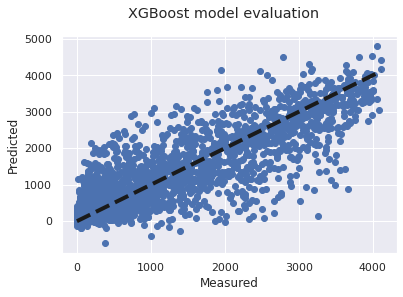

In [7]:
# Grafiek tekenen, evaluatie voorspelling
sns.set_theme()
fig, ax = plt.subplots()
ax.scatter(y_test, pred_test)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
fig.suptitle("XGBoost model evaluation")
plt.show()

## Batterij duur

Om te bepalen hoe lang de batterij mee gaat, wordt het principe `in - uit + productie = accumulatie` toegepast, vanuit het oogpunt van de batterij en de zonnepanelen. De hoeveelheid `in` is dan nul, aangenomen wordt dat de batterij niet opgeladen wordt via het net. Het energieverbruik is `uit` en wordt als constant door de dag heen beschouwd: 3500 kWh/jaar / 365 dagen/jaar / 24 uren/dag = 0.4 kWh per uur. De `productie` is de energie van de zonnepanelen. Als laatste blijft dan de `accumulatie` over, het opladen (of als deze negatief is het ontladen) van de batterij. Er wordt voor de voorspelling gestart met een volle batterij. 



/home/paulschouten/Documents/bit-academy/data-engineer-eindopdracht/venv/lib64/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


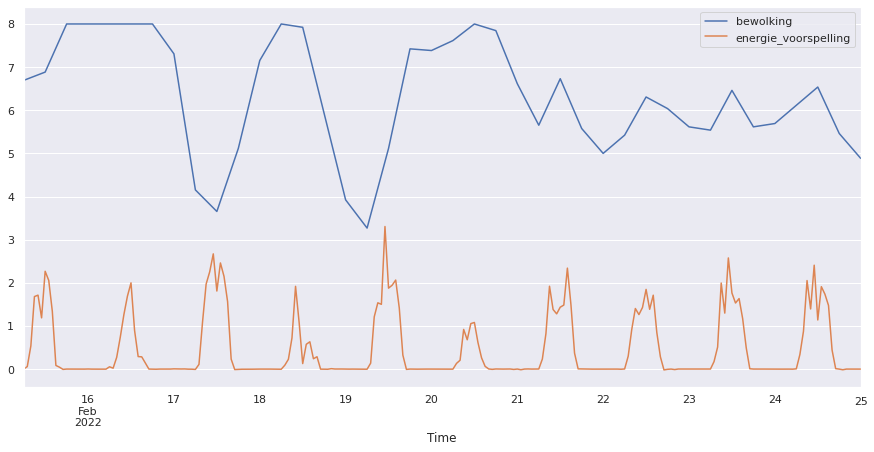

In [8]:
import pysolar

# Database inlezen
conn = sqlite3.connect("database.db")
voorspelling = pd.read_sql('SELECT * FROM knmi_forecast', conn)
conn.close()

# Tijd omzetten naar DateTime
# Toch jammer dat dit niet standaard gebeurd... (SQLite3 beperking als ik het goed heb...)
voorspelling["Time"] = pd.to_datetime(voorspelling["Tijdstip"])
voorspelling.drop(columns=["Tijdstip"], inplace=True)
voorspelling.set_index("Time", inplace=True)

# KNMI geeft per 6 uur voorspelling, interpoleren naar per uur
voorspelling = voorspelling.resample("1H").interpolate(method="linear")

# Info stand zon toevoegen
voorspelling["solar_altitude"] = pysolar.solar.get_altitude_fast(51.2, 6, voorspelling.index)
voorspelling["solar_azimuth"] = pysolar.solar.get_azimuth_fast(51.2, 6, voorspelling.index)

# Voorspelling energie berekenen:
# - Selecteren
# - Transformeren (standardscaler)
# - Prognosticeren (rijmt lekker)
X = voorspelling[["temperatuur", "bewolking", "solar_altitude", "solar_azimuth"]]
#X = scaler.fit_transform(X)
# Energie per kWh, niet per Wh
#voorspelling["energie_voorspelling"] = knn_model.predict(X) / 1000
voorspelling["energie_voorspelling"] = trained_model.predict(xgb.DMatrix(data=X)) / 1000

# Verwachting voor de komende dagen laten zien
fig, ax = plt.subplots(figsize=(15, 7))
voorspelling[["bewolking", "energie_voorspelling"]].plot(ax=ax);


In de plot is te zien dat het model op het eerste gezicht een goede voorspelling geeft: het maximum vermogen van de zonnepanelen (4.5 kWp) wordt niet overschreden. Bij meer bewolking is een lagere opbrengst te zien. In de onderstaande tabel staat het totaal per dag weergegeven:


In [9]:
voorspelling["energie_voorspelling"].resample("1D").sum().round(1).to_frame()

,energie_voorspelling
Time,
2022-02-15,11.000000
2022-02-16,7.700000
2022-02-17,16.299999
2022-02-18,5.900000
2022-02-19,15.300000
2022-02-20,5.000000
2022-02-21,12.800000
2022-02-22,11.400000
2022-02-23,13.200000


Uit bovenstaande tabel is op te maken dat de voorspelde energieproductie aan de hoge kant is. Een totaal van rond 20 kWh wordt normaal voor een zomerdag verwacht. Ondanks dit wordt het niveau van de batterij in de tijd verder uitgewerkt.

De batterij is leeg op: 2022-02-17 03:00:00


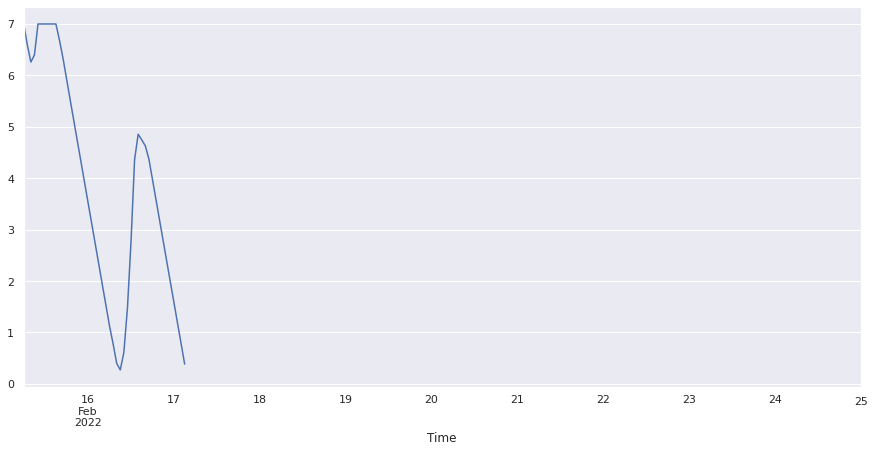

In [10]:
import math
# Nieuwe kolom aanmaken voor het niveau van de batterij,
# beginnen met een volle (7 kWh)
voorspelling["batterij"] = 0
bat_kolom = voorspelling.columns.get_loc("batterij")
voorspelling.iat[0, bat_kolom] = 7

energie_kolom = voorspelling.columns.get_loc("energie_voorspelling")

# Loop over alle rijen van het DataFrame. Op deze manier is de 
# vorige rij gemakkelijk te benaderen. Daarnaast kan het min/max
# niveau van de batterij gevolgd worden. _batterij_leeg_ wordt als
# "flag" gebruikt, om aan te geven dat de batterij leeg is.
batterij_leeg = False
for i in range(1, len(voorspelling)):
    # Opzoeken getallen om mee te rekenen
    productie = voorspelling.iloc[i-1, energie_kolom]
    accumulatie = 0 - 0.4 + productie
    bat_vorig = voorspelling.iloc[i-1, bat_kolom]
    
    # Nieuw batterijniveau berekenen, deze is:
    # - maximaal (min in deze functie) 7 kWh
    # - minimaal (max in deze functie) 0 kWh
    bat_huidig = max(min(7, bat_vorig + accumulatie), 0)
    if bat_huidig == 0 or batterij_leeg:
        batterij_leeg = True
        bat_huidig = math.nan
    
    voorspelling.iat[i, bat_kolom] = bat_huidig

fig, ax = plt.subplots(figsize=(15, 7))
voorspelling["batterij"].plot(ax=ax);

if batterij_leeg: 
    print(f'De batterij is leeg op: {max(voorspelling.dropna().index)}')
else:
    print('De batterij gaat de gehele periode mee')

Met diverse runs in februari lijkt het zelfs mogelijk om geheel autonoom te functioneren. Ook is te zien dat de batterij snel vol zit. Dat er zo lang zonder externe stroom gefunctioneerd kan worden is echter onwaarschijnlijk.

## Model evaluatie

Om het model te evalueren is onderstaande grafiek gemaakt. Deze laat in de tijd zien welke energie productie er voorspeld is versus de actuele opbrengst van de zonnepanelen. Bij herhaalde simulaties zal er ook een onzekerheid getekend worden. In verband met het verversen van de weersvoorspelling door het KNMI wordt er maar één keer per dag de simulatie opgeslagen in de database.

Ophalen evaluation OK
Getting solaredge data from 2022-02-09 06:00:00


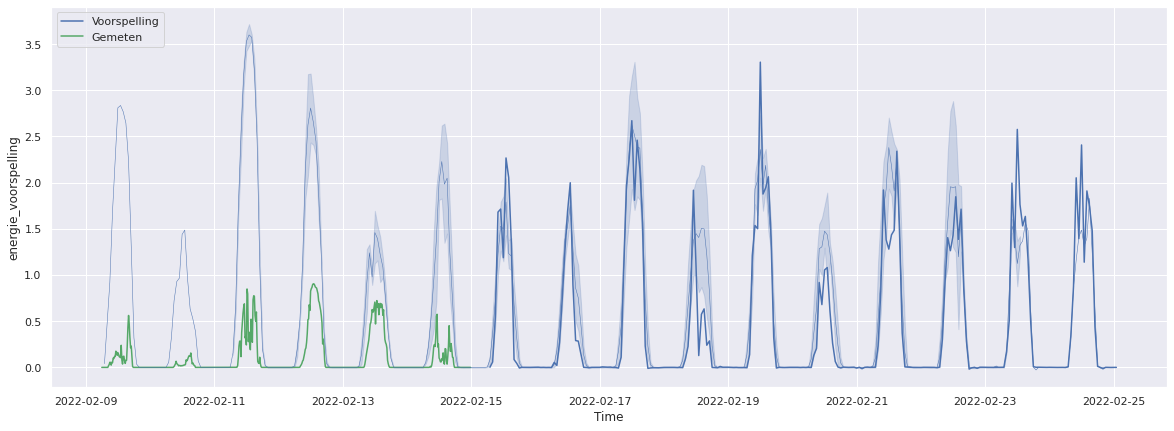

Voorspelling voor vandaag is al opgeslagen


In [11]:
# 1. Vanaf wanneer tekenen?
# Model evaluatie tekenen vanaf eerste run,
# Dit is de eerste datum in "evaluation" of anders
# de eerste datum van "voorspelling"
conn = sqlite3.connect("database.db")
cursor = conn.cursor()

# Datum opvragen in try...             except... 
#                   (tabel bestaat)... (eerste run)...
try:
    sql = 'SELECT * FROM knn_evaluation'
    previous_runs = pd.read_sql(sql, conn)
    previous_runs["Time"] = pd.to_datetime(previous_runs["Time"])
    first_date = previous_runs["Time"].min()
    print("Ophalen evaluation OK")
    
except (sqlite3.Error, pd.io.sql.DatabaseError) as e:
    print(f'Foutmelding database: {e}')
    first_date = voorspelling.index.min()
    previous_runs = None
    
print(f'Getting solaredge data from {first_date}')


# 2. Data ophalen uit database solaredge
sql = f'SELECT * FROM solaredge_history WHERE DATETIME(tijdstip) >= DATETIME("{first_date}")'
solaredge = pd.read_sql(sql, conn)

# Tijd omzetten naar datetime
solaredge["Time"] = pd.to_datetime(solaredge["tijdstip"])
solaredge.set_index("Time", inplace=True)
solaredge.drop("tijdstip", axis=1, inplace=True)

# Tijdzone info toevoegen, SolarEdge is in de "local" time
solaredge = solaredge.tz_localize("Europe/Amsterdam", ambiguous="NaT", nonexistent="NaT")

# Energie van Wh naar kWh
solaredge["energy"] = solaredge["energy"] / 1000.0

# Grafiek opbouwen
fig, ax = plt.subplots(figsize=(20, 7))
sns.lineplot(data=voorspelling, x="Time", y="energie_voorspelling", color='b', ax=ax)
sns.lineplot(data=solaredge, x="Time", y="energy", color='g', ax=ax)
if previous_runs is not None: 
    sns.lineplot(data=previous_runs, x="Time", y="energie_voorspelling", color='b', linewidth=0.5, ax=ax)
plt.legend(labels=["Voorspelling", "Gemeten"], loc="upper left")
plt.show()

# 3. Huidige voorspelling opslaan (alleen voor vandaag)
# Tabel aanmaken indien nog niet aanwezig
sql = """CREATE TABLE IF NOT EXISTS knn_evaluation_days ( 
            datum DATETIME PRIMARY KEY NOT NULL );
      """
conn.execute(sql)

# Datum van vandaag ophalen uit tabel
sql = f"SELECT datum FROM knn_evaluation_days WHERE datum = DATE('now')"
cursor.execute(sql)
result = cursor.fetchall()

if len(result) == 0:
    # Day not found, save voorspelling
    print("Voorspelling voor vandaag opslaan")
    voorspelling.to_sql("knn_evaluation", conn, if_exists="append")
    
    sql = f"INSERT INTO knn_evaluation_days VALUES ( DATE('now') )"
    cursor.execute(sql)
else:
    print("Voorspelling voor vandaag is al opgeslagen")
    
conn.commit()
conn.close()

## Evaluatie

